# Exercise MLflow
In this exercise we will uses the `diabetes` dataset in scikit-learn and predicts the progression metric (a quantitative measure of disease progression after one year after) based on BMI, blood pressure, etc. We will uses the scikit-learn ElasticNet linear regression model, where we vary the `alpha` and `l1_ratio` parameters for tuning. We will use MLflow to log  metrics, parameters, artifacts and model. For more information on ElasticNet, refer to:
  * [Elastic net regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization)
  * [Regularization and Variable Selection via the Elastic Net](https://web.stanford.edu/~hastie/TALKS/enet_talk.pdf)


**Required Libraries**: 
* `mlflow==1.7.0` via PyPI

In [0]:
%run "./Includes/Classroom-Setup"

In [0]:
!pip3 install mlflow

### Write Your ML Code Based on the`train_diabetes.py` Code
This lab is based on the MLflow's [train_diabetes.py](https://github.com/mlflow/mlflow/blob/master/examples/sklearn_elasticnet_diabetes/osx/train_diabetes.py) example, which uses the `sklearn.diabetes` built-in dataset to predict disease progression based on various factors.

In [0]:
#TODO
# Import various libraries including matplotlib, sklearn, mlflow
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

# Import mlflow
import mlflow
import mlflow.sklearn

# Load Diabetes datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Create pandas DataFrame for sklearn ElasticNet linear_model
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
data = pd.DataFrame(d, columns=cols)

### Plot the ElasticNet Descent Path
As an example of recording arbitrary output files in MLflow, plot the [ElasticNet Descent Path](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html) for the ElasticNet model by *alpha* for the specified *l1_ratio*.

The `plot_enet_descent_path` function below:
* Returns an image that can be displayed in our Databricks notebook via `display`
* As well as saves the figure `ElasticNet-paths.png` to the Databricks cluster's driver node
* Upload the file to MLflow using the `log_artifact` within `train_diabetes`

In [0]:
def plot_enet_descent_path(X, y, l1_ratio):
    # Compute paths
    eps = 5e-3  # the smaller it is the longer is the path

    # Reference the global image variable
    global image
    
    print("Computing regularization path using ElasticNet.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

    # Display results
    fig = plt.figure(1)
    ax = plt.gca()

    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')

    # Display images
    image = fig
    
    # Save figure
    fig.savefig("ElasticNet-paths.png")

    # Close plot
    plt.close(fig)

    # Return images
    return image    

### Train the Diabetes Model
The next function trains ElasticNet linear regression based on the input parameters of `alpha (in_alpha)` and `l1_ratio (in_l1_ratio)`.

In addition, this function uses MLflow Tracking to record its
* parameters
* metrics
* model
* arbitrary files, namely the above noted Lasso Descent Path plot.

**Tip:** Use `with mlflow.start_run:` in the Python code to create a new MLflow run. This is the recommended way to use MLflow in notebook cells. Whether your code completes or exits with an error, the `with` context will make sure to close the MLflow run, so you don't have to call `mlflow.end_run`.

In [0]:
#TODO
# train_diabetes
#   Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
#       The predicted "progression" column is a quantitative measure of disease progression one year after baseline
#       http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
def train_diabetes(data, in_alpha, in_l1_ratio):
  # Evaluate metrics
  def eval_metrics(actual, pred):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      r2 = r2_score(actual, pred)
      return rmse, mae, r2

  warnings.filterwarnings("ignore")
  np.random.seed(40)

  # Split the data into training and test sets. (0.75, 0.25) split.
  train, test = train_test_split(data)

  # The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
  train_x = train.drop(["progression"], axis=1)
  test_x = test.drop(["progression"], axis=1)
  train_y = train[["progression"]]
  test_y = test[["progression"]]

  if float(in_alpha) is None:
    alpha = 0.05
  else:
    alpha = float(in_alpha)
    
  if float(in_l1_ratio) is None:
    l1_ratio = 0.05
  else:
    l1_ratio = float(in_l1_ratio)
  
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # Set tracking_URI first and then reset it back to not specifying port
    # Note, we had specified this in an earlier cell
    #mlflow.set_tracking_uri(mlflow_tracking_URI)

    # Log mlflow attributes for mlflow UI
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    #log rmse
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    # log mae
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(lr, "model")
    modelpath = "/dbfs/mlflow/test_diabetes/model-%f-%f" % (alpha, l1_ratio)
    mlflow.sklearn.save_model(lr, modelpath)
    
    # Call plot_enet_descent_path
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    # Log artifacts (output files)
    mlflow.log_artifact("ElasticNet-paths.png")

### Experiment with Different Parameters

Call `train_diabetes` with different parameters. Later, you'll be able to visualize all these runs in the MLflow experiment.

In [0]:
%fs rm -r dbfs:/mlflow/test_diabetes

res1: Boolean = false

In [0]:
# alpha and l1_ratio values of 0.01, 0.01
train_diabetes(data, 0.01, 0.01)

Elasticnet model (alpha=0.010000, l1_ratio=0.010000):
 RMSE: 71.40362571026475
 MAE: 60.09124839565383
 R2: 0.2291130640003659
Computing regularization path using ElasticNet.

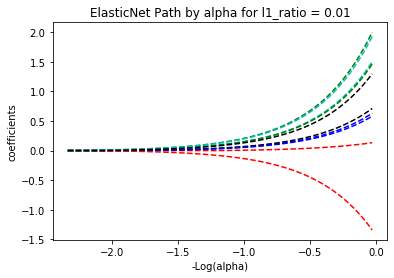

In [0]:
display(image)

In [0]:
# alpha and l1_ratio values of 0.01, 0.75
train_diabetes(data, 0.01, 0.75)

Elasticnet model (alpha=0.010000, l1_ratio=0.750000):
 RMSE: 65.28994906390733
 MAE: 53.75914828434926
 R2: 0.35547047607749416
Computing regularization path using ElasticNet.

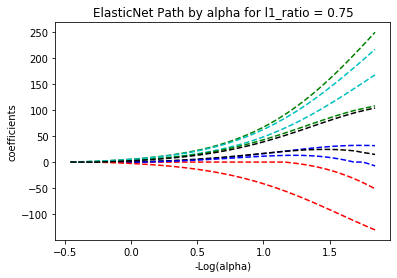

In [0]:
display(image)

In [0]:
# alpha and l1_ratio values of 0.01, .5
train_diabetes(data, 0.01, .5)

Elasticnet model (alpha=0.010000, l1_ratio=0.500000):
 RMSE: 67.98354871814037
 MAE: 56.73838604280737
 R2: 0.30119208073981796
Computing regularization path using ElasticNet.

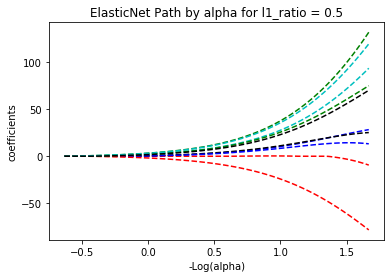

In [0]:
display(image)

In [0]:
# alpha and l1_ratio values of 0.01, 1
train_diabetes(data, 0.01, 1)

Elasticnet model (alpha=0.010000, l1_ratio=1.000000):
 RMSE: 63.24666777876805
 MAE: 51.05182860408632
 R2: 0.3951809598912357
Computing regularization path using ElasticNet.

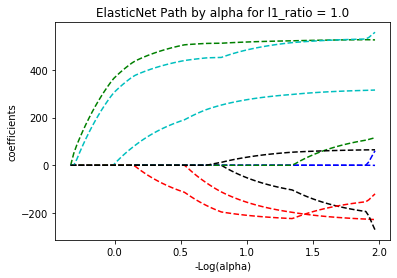

In [0]:
display(image)

### View the run, experiment, run details, and notebook revision

1. Click the **Runs** icon in the notebook context bar to display the Runs sidebar. In the sidebar, you can view the run parameters and metrics. For example: <img src="https://docs.databricks.com/_static/images/mlflow/mlflow-notebook-experiments.gif"/>
   
1. Click the External Link icon <img src="https://docs.databricks.com/_static/images/external-link.png"/> in the Runs context bar to view the notebook experiment. For example: <img src="https://docs.databricks.com/_static/images/mlflow/quick-start-nb-experiment.png"/>